In [1]:
from torch import nn
import torch
from torch.nn import functional as F
from torch import optim
import torchvision.transforms as T
from torchvision.io import read_image
import PIL
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import time

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3060 Laptop GPU'

#### Load data

In [2]:
noisy_imgs_1, noisy_imgs_2 = torch.load('../data/train_data.pkl')

In [3]:
noisy_imgs_1.shape

torch.Size([50000, 3, 32, 32])

In [4]:
noisy_imgs_2.shape

torch.Size([50000, 3, 32, 32])

In [5]:
noisy_imgs, clean_imgs = torch.load('../data/val_data.pkl')

In [7]:
train_input,train_target=noisy_imgs_1.float()/255.0,noisy_imgs_2.float()/255.0
test_input,test_target=noisy_imgs.float()/255.0,clean_imgs.float()/255.0

In [21]:
model1= nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
    )
model2=nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Conv2d(3,3,2),
            nn.ReLU(),
            nn.ConvTranspose2d(3,3,2),
            nn.ReLU(),    
            nn.Linear(128, 32)
    )
model3=nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Conv2d(3,3,2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(3,3,2,stride=2),
            nn.ReLU(),    
            nn.Linear(128, 32)
    )
model4=nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Conv2d(3,3,2,stride=2),
            nn.ReLU(),
            nn.Conv2d(3,3,4,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(3,3,4,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(3,3,2,stride=2),
            nn.ReLU(),    
            nn.Linear(128, 32)
    )
model5=nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
    )
model6=nn.Sequential(
            nn.Conv2d(3, 3,2,stride=2),
            nn.ReLU(),
            nn.Conv2d(3,3,2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(3,3,2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(3,3,2,stride=2)
    )

In [15]:
def train_model(mod,train_input,train_target,batch_size=100,lr=1e-3,nb_epochs=10):
    model=mod
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    for e in range(nb_epochs):
        print('Epoch------>',e,end=' ')
        losses=[]
        start_time = time.time()
        for b in range(0,len(train_input),batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            loss = criterion(output, train_target.narrow(0, b, batch_size))
            
            losses.append(loss)
            
            model.zero_grad()
            loss.backward()
            optimizer.step()
        current_time = time.time()
        elapsed_time = current_time - start_time
        print('Loss----->',sum(losses)/(train_input.size(0)/batch_size),end=' ')
        print('Time----->{} seconds'.format(elapsed_time),end='\n')

In [16]:
def psnr(denoised,ground_truth):
    mse=torch.mean((denoised-ground_truth)**2)
    return  - 10 * torch.log10(((denoised-ground_truth) ** 2).mean((1,2,3))).mean()
def test_model(model,test_input,test_target,batch_size):
    model_outputs = []
    for b in tqdm(range(0, test_input.size(0), batch_size)):
        output = model(test_input.narrow(0, b, batch_size))
        model_outputs.append(output)
    model_outputs = torch.cat(model_outputs, dim=0)

    output_psnr = psnr(model_outputs, test_target)
    return output_psnr

In [17]:
def save_best(models,model_results):
    torch.save(models[model_results.index(max(model_results))],'best.pth')

In [23]:
model_results=[]
models=[model1,model2,model3]
for model in models:
    print('Training model ',model)
    bs=100
    train_model(model,train_input,train_target,bs)
    res=test_model(model,test_input,test_target,bs)
    print('Validation result={}'.format(res))
    model_results.append(res)

Training model  Sequential(
  (0): Linear(in_features=32, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
)
Epoch------> 0 Loss-----> tensor(0.0161, grad_fn=<DivBackward0>) Time----->4.802769184112549 seconds
Epoch------> 1 Loss-----> tensor(0.0160, grad_fn=<DivBackward0>) Time----->4.752690553665161 seconds
Epoch------> 2 Loss-----> tensor(0.0160, grad_fn=<DivBackward0>) Time----->5.017679214477539 seconds
Epoch------> 3 Loss-----> tensor(0.0160, grad_fn=<DivBackward0>) Time----->4.898817539215088 seconds
Epoch------> 4 Loss-----> tensor(0.0160, grad_fn=<DivBackward0>) Time----->4.756211280822754 seconds
Epoch------> 5 Loss-----> tensor(0.0160, grad_fn=<DivBackward0>) Time----->4.670623064041138 seconds
Epoch------> 6 Loss-----> tensor(0.0160, grad_fn=<DivBackward0>) Time----->4.704823970794678 seconds
Epoch------> 7 Loss-----> tensor(0.0160, grad_fn=<DivBackward0>) Time----->4.686844825744629 seconds
Epoch------> 8 Loss-----> tens

In [143]:
def psnr_one(denoised,ground_truth):
    mse=torch.mean((denoised-ground_truth)**2)
    return  - 10 * torch.log10(((denoised-ground_truth) ** 2))

In [24]:
plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

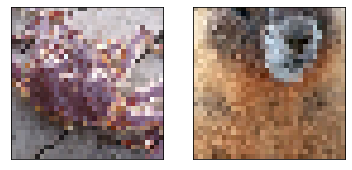

In [25]:
show(test_input[0:2])

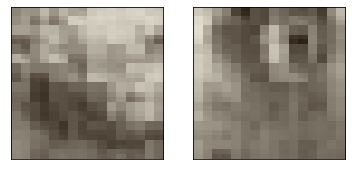

In [26]:
show(model6(test_input[0:2]))

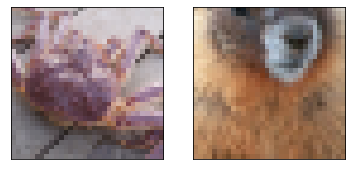

In [27]:
show(test_target[0:2])

In [ ]:
### For mini - project 1
class Model ():
    def __init__(self) -> None :
        ## instantiate model + optimizer + loss function + any other stuff you need
        self.model=
        pass

    def load_pretrained_model(self) -> None :
        ## This loads the parameters saved in bestmodel.pth into the model
        torch.load('bestmodel.pth')
        pass

    def train(self, train_input, train_target, num_epochs, batch_size) -> None :
        #: train˙input : tensor of size (N, C, H, W) containing a noisy version of the images
        #: train˙target : tensor of size (N, C, H, W) containing another noisy version of the same images , which only differs from the input by their noise .
        
        pass

    def predict(self, test_input ) -> torch.Tensor:
        #:test_input : tensor of size (N1 , C, H, W) that has to be denoised by the trained or the loaded network .
        #: returns a tensor of the size (N1 , C, H, W)
        pass